# Map of Detected Objects
### Using lat/lon of google images and object detections from YOLO model


---

### Set up

In [320]:
import os
import sys
import re
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import numpy as np

# Set up dirs for jupyter notebook using cwd
dir_name = 'PGHComputerVision'
root = os.getcwd()
# sub out any text after dir_name to get project directory
root = re.sub(rf"{dir_name}.*", dir_name, root)

# create code and data directories
code_root = os.path.join(root, 'Code')
data_root = os.path.join(root, 'Data')

# Read in helper function
sys.path.append( os.path.join(code_root, 'helpers') )
from read_in_PGH_shp_files import load_pgh_shp_files


### Set EPSG for Southern PA

In [321]:
EPSG_dict = {
    'epsg': 32129}

### Read in data

In [322]:
# read in images.txt
images_txt_path = os.path.join(data_root, 'GSV', 'Res_640', 'PittsburghDowntown_2024-03-20', 'images.txt')
images_df = pd.read_csv(images_txt_path, sep=' ', header=None)

# rename columns 
cols = ['segment_id', 'filename', 'image_panoid', 'date', 'query_counter', 'lat', 'lon', 'end']
images_df.columns = cols

# drop "end" column
images_df.drop('end', axis=1, inplace=True)

# convert date to datetime
images_df['date'] = pd.to_datetime(images_df['date'], format='%Y-%m-%d')

images_df.head(2)


,segment_id,filename,image_panoid,date,query_counter,lat,lon
0,104197837-271197326,img_104197837-271197326_h0_000.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,0.0,40.447302,-80.007539
1,104197837-271197326,img_104197837-271197326_h1_001.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,1.0,40.447302,-80.007539


In [323]:
# Convert to geopandas with lat/lon as point coordinates geometry
images_gdf = gpd.GeoDataFrame(images_df, geometry=gpd.points_from_xy(images_df.lon, images_df.lat))

# Set CRS of images to wg84
images_gdf.set_crs(epsg=4326, inplace=True)
# Convert to standard EPSG
images_gdf.to_crs(**EPSG_dict, inplace=True)

# Create Years since Today column
images_gdf['years_since_today'] = (pd.Timestamp('2024-03-20') - images_gdf['date']) 

# transform days to roughly equal years that have passed
images_gdf['years_since_today'] = round( images_gdf['years_since_today'].dt.days/365 , 2)

# Create "img_id" from 5 characters before ".png" of filename
images_gdf['img_id'] = images_gdf['filename'].str[-10:-4]

images_gdf.head(2)

,segment_id,filename,image_panoid,date,query_counter,lat,lon,geometry,years_since_today,img_id
0,104197837-271197326,img_104197837-271197326_h0_000.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,0.0,40.447302,-80.007539,POINT (408512.381 126137.263),1.72,h0_000
1,104197837-271197326,img_104197837-271197326_h1_001.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,1.0,40.447302,-80.007539,POINT (408512.381 126137.263),1.72,h1_001


# Merge in detections

In [324]:
# load detected objects df
detections = pd.read_csv( os.path.join( data_root, 'YOLO_output', 'YOLOv8m', 'detections.csv') )

# merge on segment_id and img_id
images_gdf = images_gdf.merge(detections, on=['segment_id', 'img_id'], how='left')

images_gdf.head()


,segment_id,filename,image_panoid,date,query_counter,lat,lon,geometry,years_since_today,img_id,object_id,confidence,bbox_size,x1,y1,x2,y2,class
0,104197837-271197326,img_104197837-271197326_h0_000.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,0.0,40.447302,-80.007539,POINT (408512.381 126137.263),1.72,h0_000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104197837-271197326,img_104197837-271197326_h1_001.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,1.0,40.447302,-80.007539,POINT (408512.381 126137.263),1.72,h1_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,104197837-271197326,NotSaved,XZchyShAmSwoUzzFIw9cpg,2022-07-01,2.0,40.447302,-80.007539,POINT (408512.381 126137.263),1.72,NotS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,104197837-271197326,NotSaved,XZchyShAmSwoUzzFIw9cpg,2022-07-01,3.0,40.447302,-80.007539,POINT (408512.381 126137.263),1.72,NotS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,104197837-271197326,img_104197837-271197326_h0_002.png,MYVzgzIApVIb2Z7Cdbou3w,2022-07-01,4.0,40.447208,-80.007510,POINT (408514.609 126126.715),1.72,h0_002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Read in and join `segments.json` to get streetnames

In [325]:
# read in segments json file to get segment_id to segment_name mapping
segment_path =os.path.join(data_root, 'GSV',  'segment_dictionary_PittsburghDowntown.json')
segments = pd.read_json(segment_path, orient='index')

# segment_id is a string formatted as a list. Modify it to remove brackets, comma and cocatentate with hypen
segments['segment_id'] = segments['segment_id'].apply(lambda x: x.replace('[','').replace(']', '').replace(', ','-'))

# Merge name, length and bearing to images_gdf
images_gdf_merged = images_gdf.merge(segments[['segment_id', 'name', 'length', 'bearing']], on='segment_id')


images_gdf.head(2)

,segment_id,filename,image_panoid,date,query_counter,lat,lon,geometry,years_since_today,img_id,object_id,confidence,bbox_size,x1,y1,x2,y2,class
0,104197837-271197326,img_104197837-271197326_h0_000.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,0.0,40.447302,-80.007539,POINT (408512.381 126137.263),1.72,h0_000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,104197837-271197326,img_104197837-271197326_h1_001.png,XZchyShAmSwoUzzFIw9cpg,2022-07-01,1.0,40.447302,-80.007539,POINT (408512.381 126137.263),1.72,h1_001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [326]:
# Read in PGH Shapefiles
neighbor_gdf, parks_gdf, roads_gdf, water_gdf, downtown_gdf, downtown_surrounds_gdf = load_pgh_shp_files(EPSG_dict)

# define function to plot all layers on top of each other and return the ax object
def plot_pgh_layers(title='', f_size=(10,10)):
    fig, ax = plt.subplots(figsize=f_size)
    downtown_gdf.plot(ax=ax, color='orange', alpha = .03)
    roads_gdf.plot(ax=ax, color='black', linewidth=0.5, alpha = .4)
    water_gdf.plot(ax=ax, color='blue', alpha = .7)
    parks_gdf.plot(ax=ax, color='green', alpha = .3)
    neighbor_gdf.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=0.5)
    # add title
    ax.set_title(title, fontsize=20)
    return fig, ax

---

# Plotting location of Fire Hydrants
- Deduplicate by looking at bbox size
- Buffer and merge connected geometries 

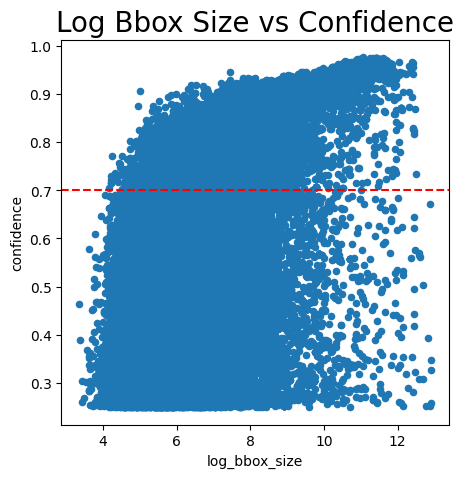

In [327]:
CONF_LEVEL = .7 # determined by looking at pictures, most under this were not fire hydrants

# plot scatterplot of log bbox size on x axis and confidence on y axis
images_gdf['log_bbox_size'] = images_gdf['bbox_size'].apply(lambda x: np.log(x) if x > 0 else np.nan) 
fig, ax = plt.subplots(figsize=(5, 5))
images_gdf.plot.scatter(x='log_bbox_size', y='confidence', ax=ax)
ax.set_title('Log Bbox Size vs Confidence', fontsize=20)
ax.axhline(y=CONF_LEVEL, color='r', linestyle='--')
plt.show()



<Axes: >

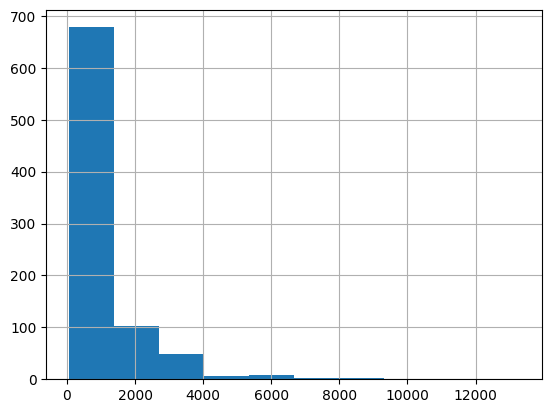

In [328]:
# Filter images_gdf to only include fire_hydrant in class and plot occurrences
fire_hydrants = images_gdf[images_gdf['class'] == 'fire_hydrant']

# For fire_hydrants, get distribution of bbox_size column by plotting hist
fire_hydrants['bbox_size'].hist()


### Filter out tiny fire hydrants (image taken far away) and low confidence detections

In [329]:
# Filter to only include bbox_size above small percentile and confidence > CONF_LEVEL
min_size = fire_hydrants['bbox_size'].quantile(0.1) 
fire_hydrants = fire_hydrants[(fire_hydrants['bbox_size'] > min_size) & (fire_hydrants['confidence'] > CONF_LEVEL)]
print(f"Min Size: {min_size}")

fire_hydrants

Min Size: 180.34


,segment_id,filename,image_panoid,date,query_counter,lat,lon,geometry,years_since_today,img_id,object_id,confidence,bbox_size,x1,y1,x2,y2,class,log_bbox_size
1363,104472649-106099212,img_104472649-106099212_h0_002.png,scto1VvZrn98d0PQA6i_aQ,2023-05-01,2.0,40.440752,-79.994567,POINT (409593.967 125382.087),0.89,h0_002,0.0,0.8653,1312.07,127.8141,393.1683,154.5430,442.2565,fire_hydrant,7.179361
1929,104482657-689935158,img_104482657-689935158_h1_017.png,ILvlP7rHKmlWj2rjDTrR7w,2023-05-01,31.0,40.436435,-79.998883,POINT (409215.747 124912.188),0.89,h1_017,1.0,0.8022,299.11,182.4778,357.7912,195.2614,381.1893,fire_hydrant,5.700811
2134,104482657-5312910369,img_104482657-5312910369_h1_003.png,MqpEjAW-Gwq5tg6PxmlnnA,2023-08-01,3.0,40.436807,-79.998470,POINT (409251.790 124952.610),0.64,h1_003,2.0,0.8550,1240.09,193.7576,388.2000,218.0450,439.2592,fire_hydrant,7.122939
2195,104482657-104945576,img_104482657-104945576_h0_000.png,Bl8ig7KbBtCQLIMwUhzEIg,2023-08-01,0.0,40.436882,-79.998419,POINT (409256.375 124960.895),0.64,h0_000,0.0,0.9248,4037.40,57.9185,448.4753,105.1089,534.0309,fire_hydrant,8.303356
2280,104482657-104945576,img_104482657-104945576_h0_006.png,vBQ_l2VkhJuGKDbL93GFLg,2022-11-01,16.0,40.437232,-79.998729,POINT (409231.072 125000.403),1.38,h0_006,1.0,0.8275,1043.63,191.6839,414.3747,213.5663,462.0673,fire_hydrant,6.950460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68103,4599846712-4599846713,img_4599846712-4599846713_h1_015.png,RXQJ2ERLl4AASddcJXNkyg,2023-05-01,39.0,40.438081,-79.997741,POINT (409317.281 125092.492),0.89,h1_015,5.0,0.7856,300.41,32.6554,344.5636,46.4734,366.3042,fire_hydrant,5.705148
68166,107653462-4599846713,img_107653462-4599846713_h0_000.png,RXQJ2ERLl4AASddcJXNkyg,2023-05-01,0.0,40.438081,-79.997741,POINT (409317.281 125092.492),0.89,h0_000,2.0,0.8252,769.18,373.1731,381.8184,393.1603,420.3019,fire_hydrant,6.645325
68179,107653462-4599846713,img_107653462-4599846713_h1_001.png,RXQJ2ERLl4AASddcJXNkyg,2023-05-01,1.0,40.438081,-79.997741,POINT (409317.281 125092.492),0.89,h1_001,3.0,0.8056,313.29,49.0566,344.7859,64.0423,365.6920,fire_hydrant,5.747129
68219,107653462-4599846713,img_107653462-4599846713_h1_005.png,sJsiz3o2lgCkQdfFfTw8uA,2023-05-01,7.0,40.437570,-79.997976,POINT (409295.922 125036.291),0.89,h1_005,1.0,0.7452,396.67,407.0343,373.1508,422.2052,399.2979,fire_hydrant,5.983105


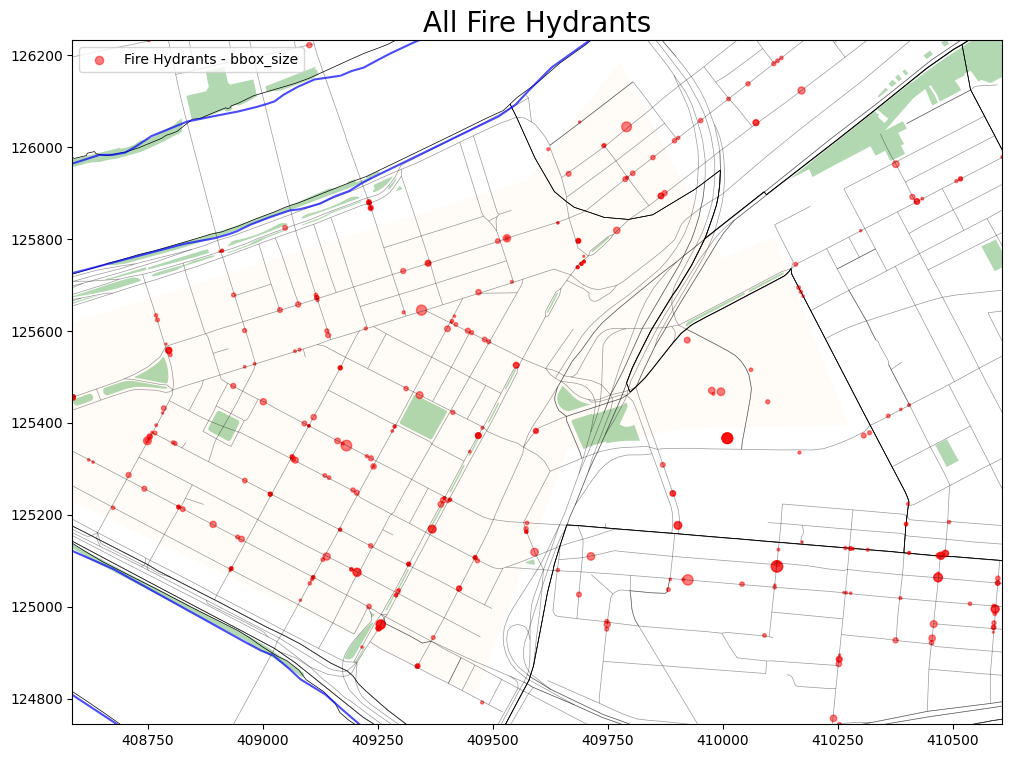

In [330]:
# Plot fire_hydrants on map
fig, ax = plot_pgh_layers("All Fire Hydrants", f_size = (12,12))
# make size of points proportional to bbox_size
fire_hydrants.plot(ax=ax, color='red', markersize=fire_hydrants['bbox_size']*.01, alpha = .5, label='Fire Hydrants - bbox_size', legend=True)

ax.set_xlim(fire_hydrants.total_bounds[0], fire_hydrants.total_bounds[2])
ax.set_ylim(fire_hydrants.total_bounds[1], fire_hydrants.total_bounds[3])

ax.legend()

### De-duplicate
- buffer small amount
- merge overlapping buffered hydrants

(124726.2800437827, 126250.02554350709)

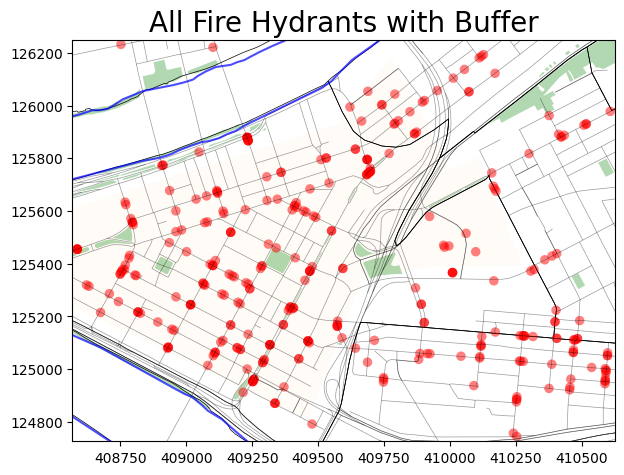

In [331]:
# Buffer a small amount to find overlapping polygons
hydrants_buffered = fire_hydrants.copy()
hydrants_buffered.loc[:, 'geometry'] = hydrants_buffered['geometry'].buffer(18)

# Plot buffers
fig, ax = plot_pgh_layers("All Fire Hydrants with Buffer", f_size = (7,7))
hydrants_buffered.plot(ax=ax, color='red', markersize=5, alpha=0.5)

ax.set_xlim(hydrants_buffered.total_bounds[0], hydrants_buffered.total_bounds[2])
ax.set_ylim(hydrants_buffered.total_bounds[1], hydrants_buffered.total_bounds[3])


### Spatial Join buffer to itself to find overlaps

/Users/coltonlapp/Dropbox/My Mac (Coltons-MacBook-Pro.local)/Desktop/SCHOOL/Year2_Spring/IndepStudyProject/PGHComputerVision/myenv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


(124726.2800437827, 126211.14210003699)

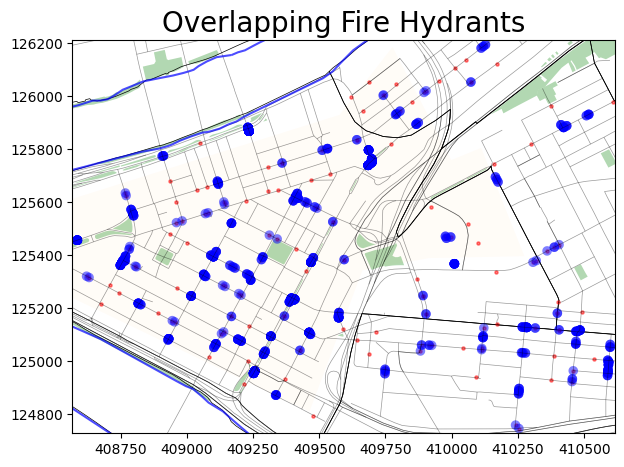

In [332]:
# Find overlapping polygons using spatial join
overlaps = gpd.sjoin(hydrants_buffered, hydrants_buffered, how='inner', op='intersects')
overlaps = overlaps[overlaps.index != overlaps.index_right]  # Remove self-overlaps

overlaps['index_left'] = overlaps.index

# Plot overlaps
fig, ax = plot_pgh_layers("Overlapping Fire Hydrants", f_size = (7,7))
fire_hydrants.plot(ax=ax, color='red', markersize=5, alpha=0.5)
overlaps.plot(ax=ax, color='blue', markersize=5, alpha=0.5)
# zoom to overlapping area
ax.set_xlim(overlaps.total_bounds[0], overlaps.total_bounds[2])
ax.set_ylim(overlaps.total_bounds[1], overlaps.total_bounds[3])


## Create group id for all overlapping points using graph

In [333]:
# Create a graph of overlapping polygons
G = nx.Graph()
for _, row in overlaps.iterrows():
    G.add_edge(row['index_left'], row['index_right'])

# Find connected components (groups of overlapping polygons)
groups = list(nx.connected_components(G))

print(f"Number of overlapping groups: {len(groups)}")

# Assign group IDs to the original GeoDataFrame
group_dict = {idx: group_id for group_id, group in enumerate(groups) for idx in group}
hydrants_buffered['group'] = hydrants_buffered.index.map(group_dict)

# In each group, keep the row with the highest value for "bbox_size"
fire_hydrants_dissolved = hydrants_buffered.groupby('group').apply(lambda x: x.loc[x['bbox_size'].idxmax()])

Number of overlapping groups: 76


/var/folders/np/9tdxr2056n39qzb1mpdsjrtc0000gn/T/ipykernel_24162/1233807971.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fire_hydrants_dissolved = hydrants_buffered.groupby('group').apply(lambda x: x.loc[x['bbox_size'].idxmax()])


## Merge overlapping groups, reset geometry to centroid of group

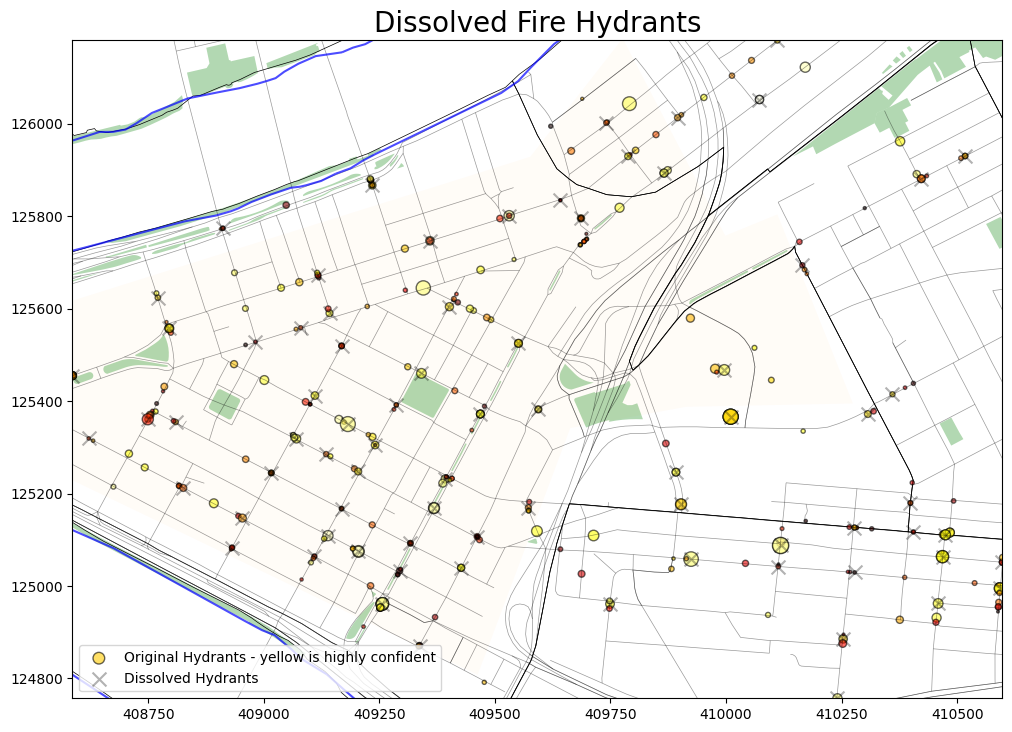

In [334]:
# Use unary_union to merge the geometries within each group
fire_hydrants_dissolved['geometry'] = fire_hydrants_dissolved.geometry.apply(lambda x: unary_union(x))

# Set geometry to centroid
fire_hydrants_dissolved['geometry'] = fire_hydrants_dissolved.geometry.centroid

# Plot dissolved fire hydrants
fig, ax = plot_pgh_layers("Dissolved Fire Hydrants", f_size = (12,12))
# plot original hydrants with size equal to bbox_size
fire_hydrants.plot(ax=ax, column=fire_hydrants['confidence'], 
                   markersize=fire_hydrants['bbox_size']*.02, edgecolor='black', cmap ='hot',
                   alpha=0.6, label='Original Hydrants - yellow is highly confident')

# plot dissolved hydrants with X marker
fire_hydrants_dissolved.plot(ax=ax, color='black', markersize=100, marker='x', alpha = .3, label='Dissolved Hydrants')

ax.set_xlim(fire_hydrants_dissolved.total_bounds[0], fire_hydrants_dissolved.total_bounds[2])
ax.set_ylim(fire_hydrants_dissolved.total_bounds[1], fire_hydrants_dissolved.total_bounds[3])


# legend
ax.legend(loc='lower left')


(124757.11408679374, 126180.64984800991)

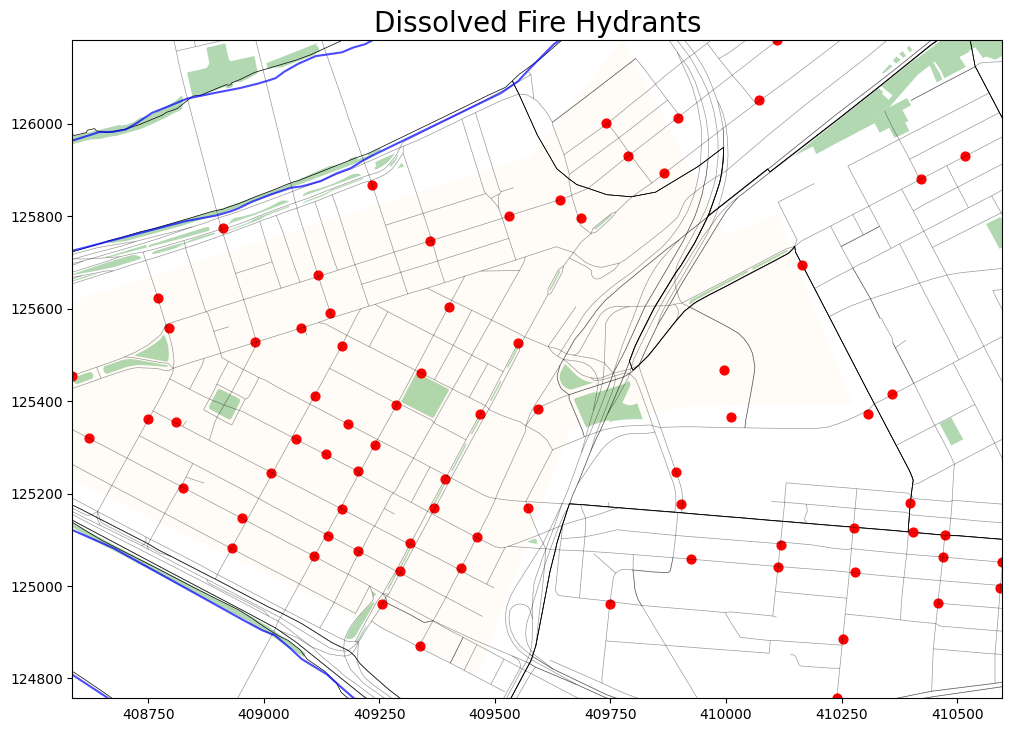

In [335]:
# Plot only dissolved
fig, ax = plot_pgh_layers("Dissolved Fire Hydrants", f_size = (12,12))
fire_hydrants_dissolved.plot(ax=ax, color='red', markersize=40, alpha = 1, label='Dissolved Hydrants')
ax.set_xlim(fire_hydrants_dissolved.total_bounds[0], fire_hydrants_dissolved.total_bounds[2])
ax.set_ylim(fire_hydrants_dissolved.total_bounds[1], fire_hydrants_dissolved.total_bounds[3])
